In [1]:
!pip install matplotlib tqdm jax

### Tutorial: From Linear Regression to Multilayer Perceptron

*Prof Christopher Tunnell, 20-May-2024, HSF-India, U. Delhi*

This tutorial will guide you through the progression from a simple linear regression model, using matrix multiplication, to a more complex model—a Multilayer Perceptron (MLP). By the end, you'll understand how both models are implemented and how to implement a neural network.  We will first implement a neural network 'by hand' before using the Haiku library for abstraction.

Please note that there are nearly infinite tutorials online that teach this material in a range of ways.  You are encouraged to search for your own websites, papers, books, or YouTube videos that match your own style of learning.

We will be using the following data that has a slight nonlinearity to show why the standard linear statistics you learn in your classes is insufficient.

**Data generation:** First we must generate some data to use later on.

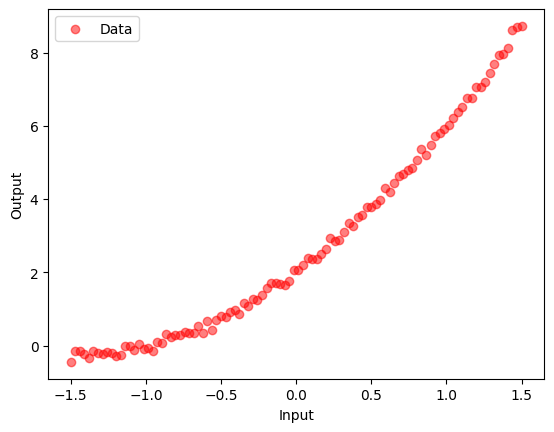

In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random, grad

# Generate synthetic data
key = random.PRNGKey(0)
x = jnp.linspace(-1.5, 1.5, 100).reshape(-1, 1)  # 100 data points, 1 feature
y = 3 * x + 2 # Linear relation
y += random.normal(key, (100, 1)) * 0.1  # Add noise
y +=  x**2 # Add slight nonlinearity

# Plotting the results
plt.scatter(x, y, color='red', alpha=0.5, label='Data')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()



#### Part 1: Understanding Linear Regression

**Linear Regression Basics:**
Linear regression is a statistical method that models the relationship between a scalar dependent variable $ \vec{y} $ and one or more independent variables (or features) denoted $ \vec{x} $. The case of one independent variable is called simple linear regression; for more than one, the process is called multiple linear regression.

**Mathematical Model:**
The equation for a linear regression is:
$$ \vec{y} = \mathbf{W} \vec{x} + b $$
where:
- $ \mathbf{W} $ represents the weights matrix.
- $ \vec{x} $ is the vector of input features.
- $ b $ is the bias.

**Matrix Multiplication:**
The heart of linear regression is the matrix multiplication between the weights $ \mathbf{W} $ and the features $ \vec{x} $. This operation scales the input data by the weights to estimate the output.

##### Example of Linear Regression in JAX:

In [3]:
# Initialize parameters
params = {'weights': jnp.array([[1.0]]), 'bias': jnp.array([0.0])}

# Prediction function
def predict(params, x):
    return jnp.dot(x, params['weights']) + params['bias']

# Loss function (Mean Squared Error)
def loss(params, x, y, predictor=predict):
    return jnp.mean((predictor(params, x) - y) ** 2)

# Gradient function
loss_grad = grad(loss)

# Update function
def update(params, x, y, learning_rate=0.1):
    gradients = loss_grad(params, x, y)
    params['weights'] -= learning_rate * gradients['weights']
    params['bias'] -= learning_rate * gradients['bias']
    return params

# Training loop
for _ in tqdm(range(100)):
    params = update(params, x, y)

print("Trained weights and bias:", params['weights'], params['bias'])
y_linear_regression = predict(params, x)

  0%|          | 0/100 [00:00<?, ?it/s]

Trained weights and bias: [[3.010272]] [2.773364]


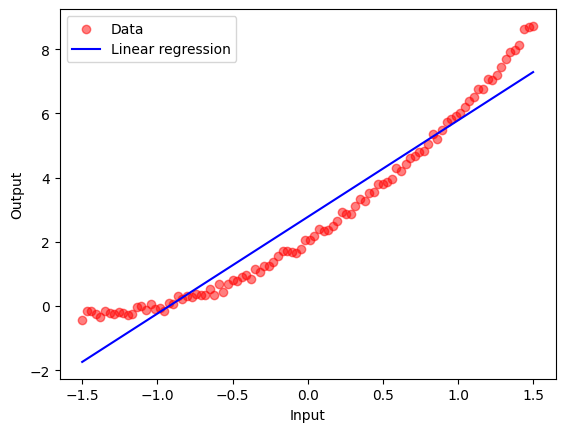

In [4]:
# Plotting the results
plt.scatter(x, y, color='red', alpha=0.5, label='Data')
plt.plot(x, y_linear_regression, color='blue', label='Linear regression')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Linear regressions can model the linear component but (unsurprisingly) are unable to model the nonlinear second-order $x^2$ corrections.


#### Part 2: Transition to a simple Multilayer Perceptron with one hidden layer

**Introduction to MLP:**
An MLP is a class of feedforward artificial neural network (ANN). Unlike linear regression that directly maps input to output, MLPs have one or more hidden layers of neurons between inputs and outputs. Each neuron in the hidden layer transforms the inputs via a linear summation followed by a non-linear activation function.

Sure, let's detail the mathematical notation for a single neural network layer using the notation from your notebook.

### Neural Network Layer Mathematical Notation

A neural network layer can be described by the following components:

- **Input Vector ( $\vec{x}$ )**: The input to the layer, which is a vector of size $n$.
- **Weight Matrix ( $\mathbf{W}$ )**: The weights associated with the connections between the input and the neurons in the layer, which is a matrix of size $m \times n$.
- **Bias Vector ($\vec{b}$)**: The biases for the neurons in the layer, which is a vector of size \(m\).
- **Activation Function ($\sigma$)**: A non-linear function applied to the weighted sum of the inputs.

For a given layer, the output vector $\vec{h}$ can be computed as follows:

$$ \vec{h} = \sigma(\mathbf{W} \vec{x} + \vec{b}) $$

Here’s a step-by-step breakdown of this formula:

1. **Linear Transformation**:
   $ \mathbf{z} = \mathbf{W} \vec{x} + \vec{b} $
   - $\mathbf{W}$: Weight matrix of size $m \times n$
   - $\vec{x}$: Input vector of size $n$
   - $\vec{b}$: Bias vector of size $m$
   - $\mathbf{z}$: Linear transformation result (pre-activation) of size $m$

2. **Non-linear Activation**:
   $ \vec{h} = \sigma(\mathbf{z}) $
   - $\sigma$: Activation function (e.g., ReLU, sigmoid, tanh)
   - $\vec{h}$: Output vector (post-activation) of size $m$

Thus, combining the two steps, we get the full transformation for a single layer in the neural network:

$$ \vec{h} = \sigma(\mathbf{W} \vec{x} + \vec{b}) $$

This notation can be generalized to multiple layers by iterating the transformation for each subsequent layer, where the output of the previous layer becomes the input for the next layer.

**From Linear to MLP:**
To transform our linear model into an MLP, we add layers with non-linear activation functions. Each layer’s output becomes the subsequent layer’s input.

##### Adjusting to two-layer MLP in JAX:



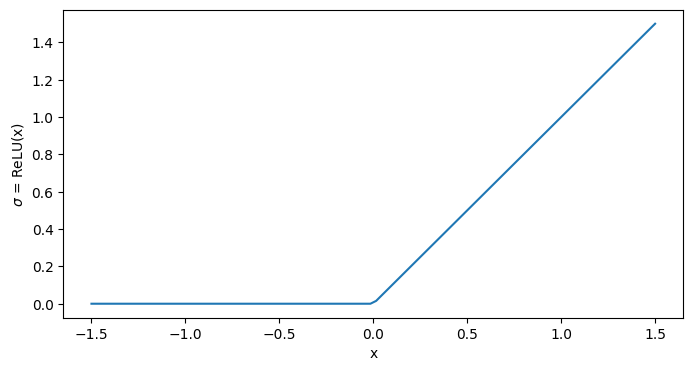

In [5]:
# Additional imports
from jax.nn import relu

# Visualize ReLU
plt.figure(figsize=(8, 4))
plt.plot(x, relu(x))
plt.xlabel('x')
_= plt.ylabel('$\sigma$ = ReLU(x)')

In [6]:
# Initialize more complex parameters
layer_size = 20
number_epochs = 1000
simple_mlp_params = {
    'w1': random.normal(key, (1, layer_size)),
    'b1': jnp.zeros(layer_size),
    'w2': random.normal(key, (layer_size, 1)),
    'b2': jnp.zeros(1)
}

# MLP prediction function
def simple_mlp_predict(params, x):
    hidden = relu(jnp.dot(x, params['w1']) + params['b1'])  # ReLU activation function
    return jnp.dot(hidden, params['w2']) + params['b2']

def simple_mlp_loss(*args):
    return loss(*args, predictor=simple_mlp_predict)

# Update function for MLP
def simple_mlp_update(params, x, y, learning_rate=0.01):
    gradients = grad(simple_mlp_loss)(params, x, y)
    return {k: v - learning_rate * gradients[k] for k, v in params.items()}

# Training loop for MLP
for _ in tqdm(range(number_epochs)):
    simple_mlp_params = simple_mlp_update(simple_mlp_params,
                                          x, y)

print("Trained MLP weights and biases:", simple_mlp_params)
y_simple_mlp = simple_mlp_predict(simple_mlp_params, x)

  0%|          | 0/1000 [00:00<?, ?it/s]

Trained MLP weights and biases: {'w1': Array([[ 0.48833865, -0.4568658 , -0.28026062, -0.01502904,  1.1164852 ,
        -0.88538957, -0.36989397, -0.14786364,  0.154538  ,  0.81861055,
        -0.48442772,  0.6535022 , -0.2396753 , -0.24810314,  0.23300497,
         0.48855287, -0.0411987 ,  0.36853674,  1.2302327 , -0.27445742]],      dtype=float32), 'b1': Array([ 0.05851207, -0.15179288, -0.09311654, -0.00499338,  0.13377638,
       -0.29417002, -0.12289695, -0.04912758,  0.01851661,  0.09808499,
       -0.16095042,  0.07830225, -0.07963183, -0.08243208,  0.02791843,
        0.05853784, -0.0136882 ,  0.04415768,  0.1474055 , -0.09118829],      dtype=float32), 'w2': Array([[ 0.47075063],
       [-0.46670285],
       [-0.28629398],
       [-0.01535266],
       [ 1.0762739 ],
       [-0.9044544 ],
       [-0.37785834],
       [-0.15104727],
       [ 0.14897218],
       [ 0.78912723],
       [-0.49485797],
       [ 0.6299671 ],
       [-0.24483638],
       [-0.2534451 ],
       [ 0.22461

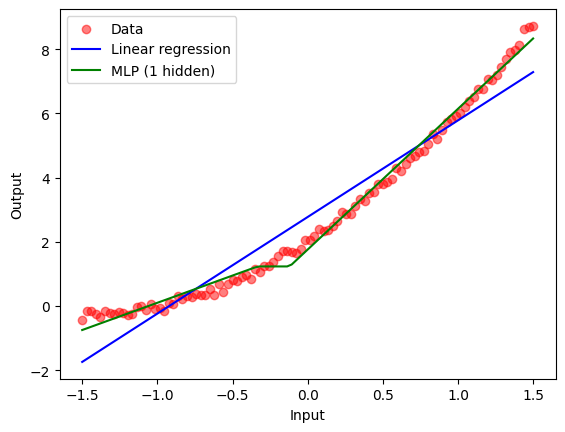

In [7]:
# Plotting the results
plt.scatter(x, y, color='red', alpha=0.5, label='Data')
plt.plot(x, y_linear_regression, color='blue', label='Linear regression')
plt.plot(x, y_simple_mlp, color='green', label='MLP (1 hidden)')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

### Part 3: Haiku-Library Neural Network with 3 Hidden Layers

In this section, we will implement a neural network using the Haiku library. This network will have three hidden layers, providing more capacity to model complex relationships in the data.

**Haiku Library:**
Haiku is a simple neural network library for JAX that makes it easy to build and experiment with neural network architectures.

**Model Architecture:**
Our model will consist of three hidden layers, each followed by a ReLU activation function, and an output layer.



In [8]:
import haiku as hk
import optax
import jax.numpy as jnp
import jax

# Define the neural network with three hidden layers
def mlp_model(x):
    mlp = hk.Sequential([
        hk.Linear(128), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(32), jax.nn.relu,
        hk.Linear(1)
    ])
    return mlp(x)

# Transform the model for Haiku
mlp_model_transformed = hk.transform(mlp_model)

# Initialize the model parameters
rng = jax.random.PRNGKey(42)
params = mlp_model_transformed.init(rng, x)

# Define the forward pass function
def forward(params, x):
    return mlp_model_transformed.apply(params, rng, x)

# Define the loss function (mean squared error)
def loss_fn(params, x, y):
    preds = forward(params, x)
    return jnp.mean((preds - y) ** 2)

# Define the optimizer
optimizer = optax.adam(learning_rate=0.001)

# Initialize the optimizer state
opt_state = optimizer.init(params)

# Training step function
@jax.jit
def train_step(params, opt_state, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# Training loop
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    params, opt_state = train_step(params, opt_state, x, y)



  0%|          | 0/1000 [00:00<?, ?it/s]

#### Comparison Plot
Let's compare the performance of the Haiku-based neural network with the previous models.


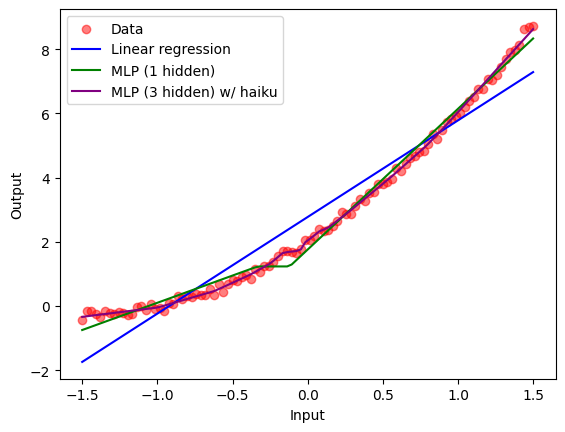

In [9]:
import matplotlib.pyplot as plt

# Predict using the trained Haiku model
y_haiku = forward(params, x)

# Plotting the results
plt.scatter(x, y, color='red', alpha=0.5, label='Data')
plt.plot(x, y_linear_regression, color='blue', label='Linear regression')
plt.plot(x, y_simple_mlp, color='green', label='MLP (1 hidden)')
plt.plot(x, y_haiku, color='purple', label='MLP (3 hidden) w/ Haiku')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

In [10]:
#### Question for bonus points

Why does 3 hidden layers results in a model that predicts every data point so well?  Please lookup the term 'overfitting' where 'test train splits' are the solution.  We will discuss this in another tutorial.

SyntaxError: invalid syntax (<ipython-input-10-16c97b95cb21>, line 3)